In [127]:
#%reset
%matplotlib inline
from matplotlib import ticker
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import netCDF4 as nc
#import warnings; warnings.filterwarnings('ignore')
import cmocean
#from gsw import alpha, SA_from_SP, p_from_z, CT_from_pt, beta, sigma1 
from eofs.standard import Eof
import cartopy
import cartopy.crs as ccrs

### For CM2.6 data:

In [2]:
%cd /net2/smg/documents/OMDT/analysis_CM2p6/grids
os = xr.open_dataset('ocean.static.nc')
fs = xr.open_dataset('ocean_grid.nc')
depth=fs['ht'][:,:]

lon=fs['geolon_t'][::10,::10]; lat=fs['geolat_t'][::10,::10]
# Coriolis is 2Omega sin(phi) where phi is the latitude of the B-grid velocity point, which should be available in hgrid
Coriolis = 2*7.29e-5*np.sin(fs['geolat_c']/360 *2*np.pi);

%cd /work/eay/
u_full = nc.Dataset('u_1year_CM2.6.nc')['u_full']
v_full = nc.Dataset('v_1year_CM2.6.nc')['v_full']
zl = np.array(nc.Dataset('v_1year_CM2.6.nc')['st_ocean'])
print('done')

#%cd /archive/Richard.Slater/CM2.6/CM2.6_A_Control-1860_V03/history
# z = u_full.st_ocean
# z_edges  = xr.open_dataset('02020101.ocean_minibling_field_u.nc')['st_edges_ocean']
# thickness= z_edges.diff('st_edges_ocean').rename({'st_edges_ocean': 'st_ocean'}).assign_coords({"st_ocean":u_full.st_ocean})

# print(thickness)


/net2/smg/documents/OMDT/analysis_CM2p6/grids
/work2/eay
done


In [84]:
lon_coarse = fs.xt_ocean[::10]
lat_coarse = fs.yt_ocean[::10]
lat_coarse.shape
depth_coarse = depth[::10,::10]

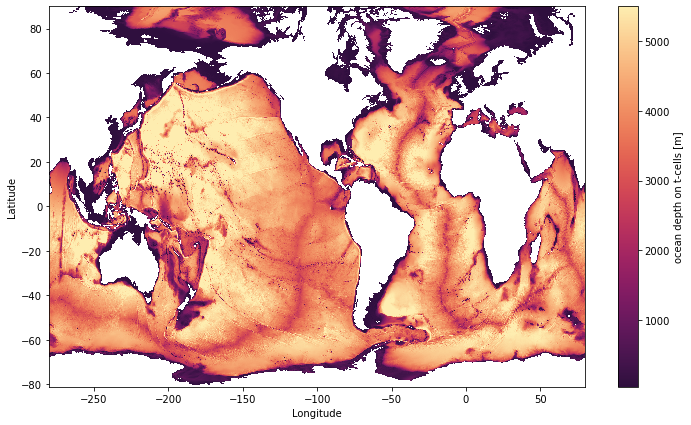

In [4]:
fig=depth.plot(figsize=(12, 7),cmap=cmocean.cm.matter_r)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

In [5]:
%cd /work/eay/
ds_EOF = xr.open_dataset('EOF_analysis_CM2.6.nc')
print(ds_EOF)
pvaru = ds_EOF.pvaru
pvarv = ds_EOF.pvarv
EOFu = ds_EOF.EOF1u
EOFv = ds_EOF.EOF1v
zl    = ds_EOF.zl

/work2/eay
<xarray.Dataset>
Dimensions:  (zl: 50, lat: 270, lon: 360)
Coordinates:
  * zl       (zl) float64 5.034 15.1 25.22 ... 4.975e+03 5.185e+03 5.395e+03
  * lat      (lat) float64 -81.11 -80.69 -80.26 -79.84 ... 88.75 89.18 89.6
  * lon      (lon) float64 -279.9 -278.9 -277.9 -276.9 ... 77.05 78.05 79.05
Data variables:
    EOF1u    (zl, lat, lon) float32 ...
    EOF1v    (zl, lat, lon) float32 ...
    pvaru    (lat, lon) float32 ...
    pvarv    (lat, lon) float32 ...


In [6]:
zl.shape

(50,)

In [7]:
# fig = plt.figure(figsize=(8, 4), dpi= 150, facecolor='w', edgecolor='k')

# plot0 = plt.pcolor(lon_coarse,lat_coarse,np.ones([270,360]),cmap='Greys',vmin=0,vmax=4)
# plot1 =plt.pcolor(lon_coarse,lat_coarse,pvaru*100,cmap=cmocean.cm.thermal,vmin=65,vmax=100)
# plot1.cmap.set_under('#ADD8E6')

# plt.colorbar()
# #plt.grid()
# #plt.xlim(-.2,.2)
# #plt.ylim(-5500, 0);
# plt.title('Percent variance explained by EOF1 for U',fontsize=12)
# plt.ylabel('Latitude',fontsize=12)
# plt.xlabel('Longitude',fontsize=12)

In [11]:
pvaru.shape

(270, 360)

In [11]:
print(EOFu)
print(EOFv)

<xarray.DataArray 'EOF1u' (zl: 50, lat: 270, lon: 360)>
[4860000 values with dtype=float32]
Coordinates:
  * zl       (zl) float64 5.034 15.1 25.22 ... 4.975e+03 5.185e+03 5.395e+03
  * lat      (lat) float64 -81.11 -80.69 -80.26 -79.84 ... 88.75 89.18 89.6
  * lon      (lon) float64 -279.9 -278.9 -277.9 -276.9 ... 77.05 78.05 79.05
<xarray.DataArray 'EOF1v' (zl: 50, lat: 270, lon: 360)>
[4860000 values with dtype=float32]
Coordinates:
  * zl       (zl) float64 5.034 15.1 25.22 ... 4.975e+03 5.185e+03 5.395e+03
  * lat      (lat) float64 -81.11 -80.69 -80.26 -79.84 ... 88.75 89.18 89.6
  * lon      (lon) float64 -279.9 -278.9 -277.9 -276.9 ... 77.05 78.05 79.05


Compute depths of zero crossings. Save the number of zero crossings and the depth of the first zero crossing. 

In [85]:
#EOFu_local = EOFu[:,142,139].dropna(dim='zl')
EOFu_local = EOFu[:,50,50].dropna(dim='zl')

zero_crossings = np.where(np.diff(np.signbit(EOFu_local)))[0]+1
print(zero_crossings)
if len(zero_crossings)>0:
    for k in range(len(zero_crossings)):
        print(k)
        print(zero_crossings[k])
        print(zl[(zero_crossings[k])])
else:
    print('no crossings')
    print(depth_coarse[50,50].values)
# output: [1]

[]
no crossings
4621.7587890625


(2700, 3600)

In [87]:
size = EOFu.shape
zero_crossings_U = EOFu*np.nan
zero_crossings_V = EOFu*np.nan
num_crossings_U = EOFu[0,:,:]*np.nan
num_crossings_V = EOFv[0,:,:]*np.nan

for i in range(0,size[1]):
    for j in range(0,size[2]):
        EOFu_local = EOFu[:,i,j].dropna(dim='zl')
        EOFv_local = EOFv[:,i,j].dropna(dim='zl')
        if len(EOFu_local)>5:
            zero_crossings = np.where(np.diff(np.signbit(EOFu_local)))[0]+1
            num_crossings_U[i,j]=len(zero_crossings)   
            if len(zero_crossings)>0:
                for k in range(len(zero_crossings)):
                    zero_crossings_U[k,i,j] = zl[(zero_crossings[k])]
            else:
                zero_crossings_U[0,i,j]=depth_coarse[i,j].values
                
        if len(EOFv_local)>5:
            zero_crossings = np.where(np.diff(np.signbit(EOFv_local)))[0]+1
            num_crossings_V[i,j]=len(zero_crossings) 
            if len(zero_crossings)>0:
                for k in range(len(zero_crossings)):
                    zero_crossings_V[k,i,j] = zl[(zero_crossings[k])]
            else:
                zero_crossings_V[0,i,j]=depth_coarse[i,j].values

    print(i)    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269


In [88]:
land_mask = depth.fillna(1)
land_mask = land_mask.where(land_mask==1)
print('done')

done


NameError: name 'depth' is not defined

In [101]:
test = (zero_crossings_U[0,:,:].values)/depth_coarse.values

In [102]:
test.shape

(270, 360)

Text(0.5, 0, 'Longitude')

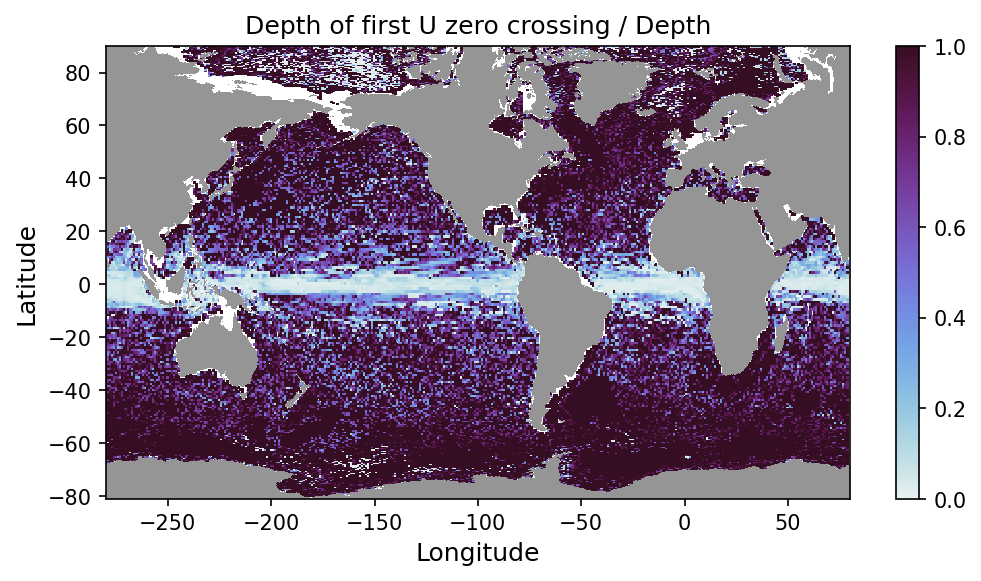

In [110]:
fig = plt.figure(figsize=(8, 4), dpi= 150, facecolor='w', edgecolor='k')


plot1 = plt.pcolor(lon_coarse,lat_coarse,(zero_crossings_U[0,:,:].values)/depth_coarse.values,cmap=cmocean.cm.dense,vmin=0,vmax=1)
land_mask.plot(vmin=0,vmax=2,cmap='Greys',add_colorbar=False)
#plt.ylim(-50,50);
plt.colorbar()
plt.title('Depth of first U zero crossing / Depth',fontsize=12)
plt.ylabel('Latitude',fontsize=12)
plt.xlabel('Longitude',fontsize=12)

Text(0.5, 0, 'Longitude')

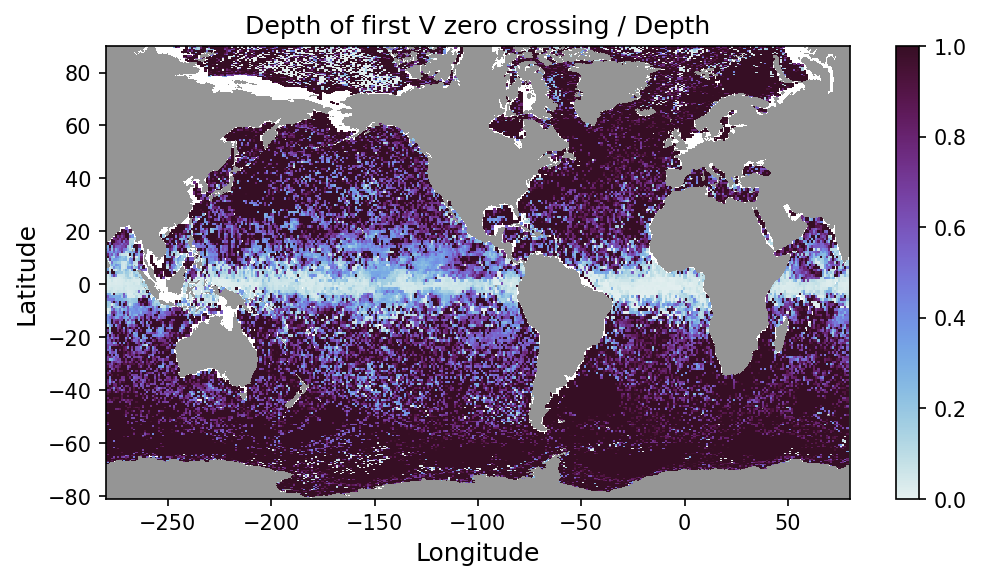

In [111]:
fig = plt.figure(figsize=(8, 4), dpi= 150, facecolor='w', edgecolor='k')


plot1 = plt.pcolor(lon_coarse,lat_coarse,(zero_crossings_V[0,:,:].values)/depth_coarse.values,cmap=cmocean.cm.dense,vmin=0,vmax=1)
land_mask.plot(vmin=0,vmax=2,cmap='Greys',add_colorbar=False)
#plt.ylim(-50,50);
plt.colorbar()
plt.title('Depth of first V zero crossing / Depth',fontsize=12)
plt.ylabel('Latitude',fontsize=12)
plt.xlabel('Longitude',fontsize=12)

Text(0.5, 0, 'Longitude')

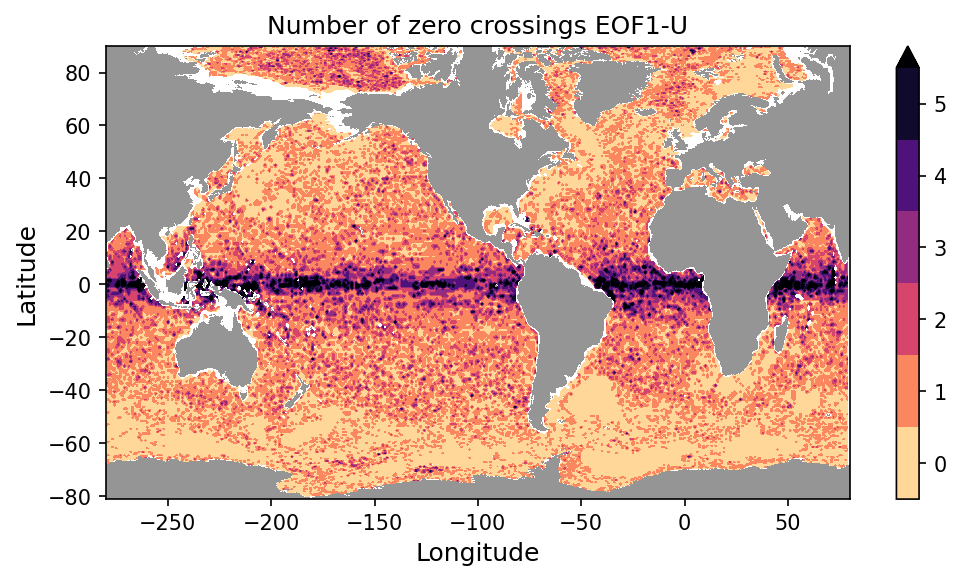

In [125]:
fig = plt.figure(figsize=(8, 4), dpi= 150, facecolor='w', edgecolor='k')

#plot0 = plt.pcolor(lon_coarse,lat_coarse,np.ones([270,360]),cmap='Greys',vmin=0,vmax=3)
levels=np.linspace(-.5,5.5,7)
plot1 = plt.contourf(lon_coarse,lat_coarse,num_crossings_U,cmap='magma_r',levels=levels,extend='max')
land_mask.plot(vmin=0,vmax=2,cmap='Greys',add_colorbar=False)
#plt.ylim(-50,50);

plt.colorbar(ticks=[0, 1, 2, 3, 4, 5])
#cbar = fig.colorbar(ticks=[0, 1,2,3,4,5])
plt.title('Number of zero crossings EOF1-U',fontsize=12)
plt.ylabel('Latitude',fontsize=12)
plt.xlabel('Longitude',fontsize=12)

Text(0.5, 0, 'Longitude')

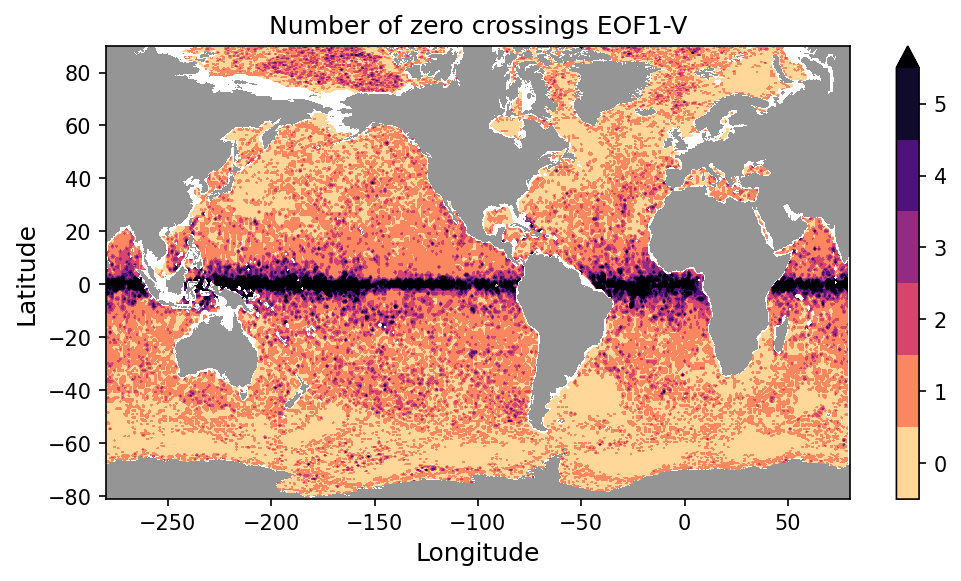

In [126]:
fig = plt.figure(figsize=(8, 4), dpi= 150, facecolor='w', edgecolor='k')

#plot0 = plt.pcolor(lon_coarse,lat_coarse,np.ones([270,360]),cmap='Greys',vmin=0,vmax=3)
levels=np.linspace(-.5,5.5,7)
plot1 = plt.contourf(lon_coarse,lat_coarse,num_crossings_V,cmap='magma_r',levels=levels,extend='max')
land_mask.plot(vmin=0,vmax=2,cmap='Greys',add_colorbar=False)
#plt.ylim(-50,50);

plt.colorbar(ticks=[0, 1, 2, 3, 4, 5])
#cbar = fig.colorbar(ticks=[0, 1,2,3,4,5])
plt.title('Number of zero crossings EOF1-V',fontsize=12)
plt.ylabel('Latitude',fontsize=12)
plt.xlabel('Longitude',fontsize=12)